#Exercise III: Cart-Pole with TD(0)

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import random
import math

from collections import defaultdict

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
env = gym.make("CartPole-v0")
env.reset()


array([-0.00878473, -0.03004611, -0.04490942, -0.00323586])

In [ ]:
states = (1, 1, 6, 3)  # (x, x', theta, theta')
actions = env.action_space.n 

limit = list(zip(env.observation_space.low, env.observation_space.high))
limit[1] = [-1, 1]
limit[3] = [-math.radians(50), math.radians(50)]
def observation_to_state(observation):
    states_list = []
    for i in range(len(observation)):
        if observation[i] <= limit[i][0]:
            index = 0
        elif observation[i] >= limit[i][1]:
            index = states[i] - 1
        else:
            # map the state bounds to the state array
            width = limit[i][1] - limit[i][0]
            offset = (states[i]-1)*limit[i][0]/width
            scaling = (states[i]-1)/width
            index = int(round(scaling*observation[i] - offset))
        states_list.append(index)
    return tuple(states_list)

In [ ]:
def epsilon_greedy_policy(Q, epsilon, nA):
   
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

#a. On-policy SARSA

In [ ]:

def on_policy_sarsa(env, num_episodes, discount_factor=0.9, alpha=0.5, epsilon=0.1):

    Qtable = defaultdict(lambda: np.zeros(env.action_space.n)) #Q table for all (s,a)
  
    episode_lengths=np.zeros(num_episodes)
    episode_rewards=np.zeros(num_episodes)

    policy = epsilon_greedy_policy(Qtable, epsilon, env.action_space.n) #obtain policy
    
    for i_episode in range(num_episodes):         
        obs = env.reset()# Reset and pick the first action
        prev_screen = env.render(mode='rgb_array')
        plt.imshow(prev_screen)
        state=observation_to_state(obs)
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
        for t in range(20000):
            # Take a step
            print("step i",t,"action=",action,"\n")
            next_obs, reward, done, info = env.step(action)
            print("Next observation=",next_obs,"reward=",reward,"done=",done,"info=",info,"\n")
            next_state=observation_to_state(next_obs)
            
            next_action_probs = policy(next_state) #next action
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            episode_rewards[i_episode] += reward
            episode_lengths[i_episode] = t
            
            # TD Update
            td_target = reward + discount_factor * Qtable[next_state][next_action]
            td_delta = td_target - Qtable[state][action]
            Qtable[state][action] += alpha * td_delta
    
            screen = env.render(mode='rgb_array')
            plt.imshow(screen)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

            if done:
                break
                
            action = next_action
            state = next_state   
    ipythondisplay.clear_output(wait=True)
    env.close()
    print("Iterations that were run:",t)
     
    
    return Qtable

Iterations that were run: 18



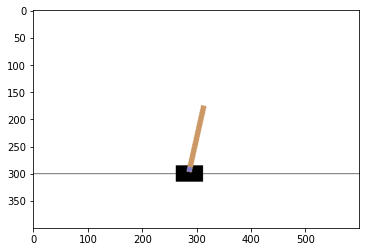

In [ ]:
q1=on_policy_sarsa(env,2)

In [ ]:
for s,a in q1.items():
  print(s,":",a)


(0, 0, 3, 1) : [4.97465411 0.        ]
(0, 0, 3, 2) : [1.54746774 2.91254919]
(0, 0, 4, 2) : [1.8549375 0.       ]
(0, 0, 4, 1) : [0.93875 0.     ]


#b. Off-policy Q learning

In [ ]:
def select_action(state, explore_rate):
    # select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # select the action with the highest q
    else:
        action = np.argmax(q_table[state])
    return action

# learning related constants
min_explore_rate = 0.01
min_learning_rate = 0.1

def get_explore_rate(t):
    return max(min_explore_rate, min(1, 1.0 - math.log10((t+1)/25)))
def get_learning_rate(t):
    return max(min_learning_rate, min(0.5, 1.0 - math.log10((t+1)/25)))


In [ ]:
import logging
logger = logging.getLogger('my_logger')
logging.basicConfig()

q_table = defaultdict(lambda: np.zeros(env.action_space.n)) #Q table for all (s,a)
def off_policy_Qlearning(env,max_iteration):
  time_steps = 2000
  success_to_end = 5
  num_success = 0
  success_time=200
  learning_rate = get_learning_rate(0)
  explore_rate = get_explore_rate(0)
  gamma=0.9
  
  for i in range(max_iteration):
    obser= env.reset()
  
    total_reward = 0
    state_0 = observation_to_state(obser)
    for t1 in range(time_steps):
      env.render()
      action1 = select_action(state_0, explore_rate)

      obser, rew, done1, info1 = env.step(action1)
      print("step i",t1,"action=",action1,"\n")
      print("Next observation=",obser,"reward=",rew,"done=",done1,"\n")
      state = observation_to_state(obser) 
      best_q = max(q_table[state])# update the Q table 
      q_table[state_0][action1] = q_table[state_0][action1]  + learning_rate * (rew + gamma * (best_q) - q_table[state_0][action1]) 
      state_0 = state
      total_reward += rew
      
      if done1:
        print("Iteration No:", i+1,"TimeSteps:",t1," Success:",num_success, "Best Q:",best_q,"Explore rate:",explore_rate,"Learning rate:",learning_rate,"Total reward:", total_reward)
        if t1>=success_time:
          num_success+=1
        else:
          num_success=0
        break
      
    # break when it's solved over num_success=5 times consecutively
      if num_success > success_to_end:
          break
    print("Episode",i+1 ,"terminated after",t1,"Iterations ")
  ipythondisplay.clear_output(wait=True)
  env.close()
  
  explore_rate = get_explore_rate(i)
  learning_rate = get_learning_rate(i)
  return q_table, total_reward

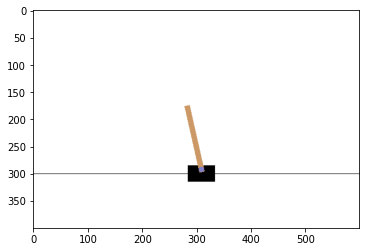

In [ ]:
q2,re=off_policy_Qlearning(env,5)

#####Sample output

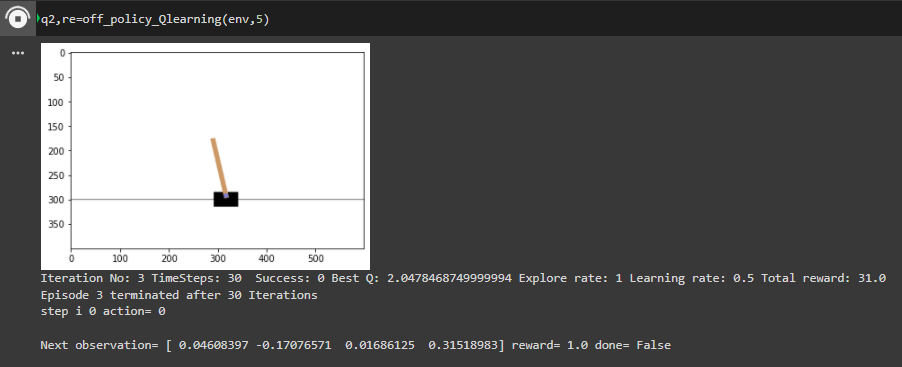

In [ ]:
print("Total reward in last episode:",re)

Total reward in last episode: 27.0


#c. Off-policy Expected SARSA with an epsilon-greedy policy

In [ ]:
Q_table = defaultdict(lambda: np.zeros(env.action_space.n))

def select_action(state, explore_rate):
    # select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # select the action with the highest q
    else:
      qlist=list(Q_table[state])
      action = qlist.index(max(qlist)) 
    return action

def off_policy_expectedSARSA(env,num_episodes):
  epsilon = 0.1 # Exploration rate
  alpha = 0.5 # Step size 
  gamma = 0.9
  max_steps=200
  epreward=0
  totreward=[]
  e=0.1
  for i in range(num_episodes):
    prev_state = env.reset()
    prev_state=observation_to_state(prev_state)
    prev_action =select_action(prev_state,e)
    epreward = 0

    for t2 in range(max_steps):
      new_state, reward1, done2, _ = env.step(prev_action)
      new_state=observation_to_state(new_state)
      new_action = select_action(new_state,e)
      oldQ=Q_table[prev_state][prev_action]
      expected_q=0
      qmax = max(Q_table[prev_state])
      greedy_actions = 0
      for j in range(actions):
          if Q_table[new_state][j] == qmax:
            greedy_actions += 1
     
      p1 = epsilon / actions #non-greedy action prob
      p2 = ((1 - epsilon) / greedy_actions) + p1 #greedy_action_probability
      for k in range(actions):
            if Q_table[new_state][k] == qmax:
                expected_q += Q_table[new_state][k] * p2
            else:
                expected_q += Q_table[new_state][k] * p1
      Q_table[prev_state, prev_action] += alpha * (reward1 + gamma * expected_q - oldQ)
      prev_state=new_state
      prev_action=new_action
      epreward+=reward1
      print("Episode no.:",i,"Timestep:",t2)
      screen2 = env.render(mode='rgb_array')
      plt.imshow(screen2)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
      if done2:
        break
  totreward.append(epreward)    
  print("Mean Expected return",np.mean(totreward))
  ipythondisplay.clear_output(wait=True)
  env.close()
  return Q_table , np.mean(totreward)   


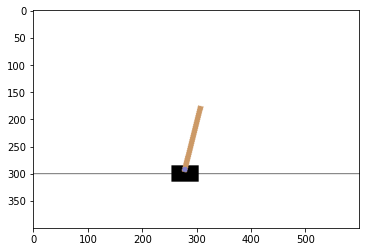

In [ ]:
q3,re1=off_policy_expectedSARSA(env,5)

###Sample output:

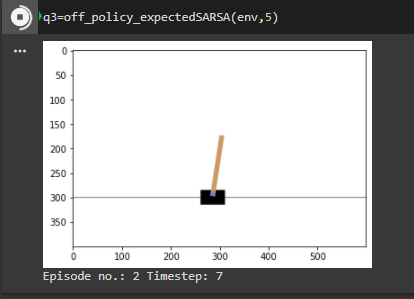

In [ ]:
print("Mean expected reward=",re1)

Mean expected reward= 9.0
